In [30]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8b8dyrj6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8b8dyrj6
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [31]:
!pip install transformers

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


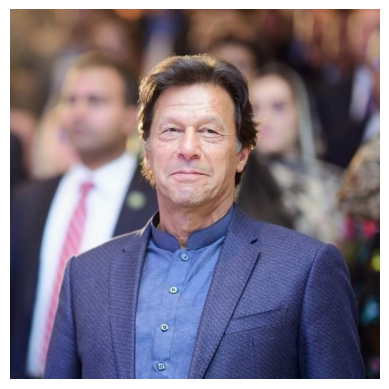

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image from Google Drive
image_path = "/content/drive/My Drive/Image_Date/image1.jpg"
image = Image.open(image_path)

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import os
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained Mask R-CNN model and move it to the device
model = maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

# Input and output directories (modify these paths as per your setup)
input_dir = '/content/drive/My Drive/train_images'  # Replace with your input image folder path
output_dir = '/content/drive/My Drive/output_processing'  # Replace with your output folder path
os.makedirs(output_dir, exist_ok=True)

# List all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

for image_file in image_files:
    # Load the image and move it to the device
    image_path = os.path.join(input_dir, image_file)
    image = Image.open(image_path)
    image = F.to_tensor(image).to(device)

    # Perform the detection
    with torch.no_grad():
        predictions = model([image])

    # Get the masks of detected humans
    masks = predictions[0]['masks']

    # Find the largest region (the largest detected human)
    largest_mask = None
    largest_area = 0
    for i in range(masks.shape[0]):
        mask = masks[i, 0]
        area = mask.sum().item()
        if area > largest_area:
            largest_mask = mask
            largest_area = area

    # Crop the image to include only the largest detected human
    human_image = image * largest_mask

    # Save the image with the full human in the output directory
    output_path = os.path.join(output_dir, f'human_{image_file}')
    human_image = F.to_pil_image(human_image.cpu())  # Convert back to CPU for saving
    human_image.save(output_path)

# Processed images with detected humans are saved in the output directory
print(f"Processed {len(image_files)} images.")


In [35]:
!pip install torch torchvision transformers

In [42]:
import torch
import torch.nn as nn

class CustomContrastiveLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin
        self.cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, image_embeddings, labels):
        # Ensure the size of the labels matches the batch size
        if len(labels) != len(image_embeddings):
            raise ValueError("Number of labels must match the batch size.")

        # Calculate pairwise cosine similarity
        cosine_sim = self.cosine_similarity(image_embeddings.unsqueeze(1), image_embeddings.unsqueeze(0))

        # Create a mask to identify positive and negative pairs
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()

        # Compute the loss
        positive_loss = torch.sum((1 - cosine_sim) * mask)
        negative_loss = torch.sum(torch.relu(cosine_sim - self.margin) * (1 - mask))

        loss = positive_loss + negative_loss

        return loss

# Usage example
batch_size = 16  # Adjust to match your batch size
embedding_size = 512  # Adjust to match your embedding size

image_embeddings = torch.rand(batch_size, embedding_size)  # Replace with actual image embeddings
labels = torch.randint(0, 2, (batch_size,))  # Binary labels (1 for positive pairs, 0 for negative pairs)

criterion = CustomContrastiveLoss()
loss = criterion(image_embeddings, labels)


RuntimeError: ignored

In [43]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AdamW
from PIL import Image

# Check if a GPU is available, and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
gdrive_dir = "/content/drive/MyDrive"
data_dir = os.path.join(gdrive_dir, "output_processing")
output_dir = os.path.join(gdrive_dir, "fine_tuned_clip_model")

# Load the pre-trained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Define a Custom Dataset Class (assuming images are in a single folder)
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, processor):
        self.data_dir = data_dir
        self.image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        inputs = self.processor(text=None, images=image, return_tensors="pt")
        return inputs

# Create DataLoader
dataset = CustomImageDataset(data_dir, processor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Define the optimizer for the entire model
optimizer = AdamW(model.parameters(), lr=1e-4)

# Define your custom contrastive loss function
import torch.nn as nn

class CustomContrastiveLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin
        self.cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, image_embeddings, labels):
        # Ensure the size of the labels matches the batch size
        if len(labels) != len(image_embeddings):
            raise ValueError("Number of labels must match the batch size.")

        # Calculate pairwise cosine similarity
        cosine_sim = self.cosine_similarity(image_embeddings.unsqueeze(1), image_embeddings.unsqueeze(0))

        # Create a mask to identify positive and negative pairs
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()

        # Compute the loss
        positive_loss = torch.sum((1 - cosine_sim) * mask)
        negative_loss = torch.sum(torch.relu(cosine_sim - self.margin) * (1 - mask))

        loss = positive_loss + negative_loss

        return loss

# Fine-tuning loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}

        optimizer.zero_grad()

        # You should have both text and images in inputs
        outputs = model(**inputs)
        image_embeddings = outputs.last_hidden_state  # Extract image embeddings
        labels = torch.randint(0, 2, (len(inputs["input_ids"]),))  # Binary labels (1 for positive pairs, 0 for negative pairs)

        criterion = CustomContrastiveLoss()
        loss = criterion(image_embeddings, labels)

        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")

# Save the fine-tuned model
model.save_pretrained(output_dir)

# Move the saved model to Google Drive
!mv $output_dir $gdrive_dir


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


RuntimeError: ignored